Assignment 4
Aleksander Moeslund Wael
02/12/2021

# Exercises and objectives

1) Use principal component analysis to improve the classification of subjective experience  
2) Use logistic regression with cross-validation to find the optimal number of principal components 

# EXERCISE 1 - Use principal component analysis to improve the classification of subjective experience  

We will use the same files as we did in Assignment 3.

The files `megmag_data.npy` and `pas_vector.npy` can be downloaded here (http://laumollerandersen.org/data_methods_3/megmag_data.npy) and here (http://laumollerandersen.org/data_methods_3/pas_vector.npy)

The function `equalize_targets` is supplied - this time, we will only work with an equalized data set. One motivation for this is that we have a well-defined chance level that we can compare against. Furthermore, we will look at a single time point to decrease the dimensionality of the problem

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
plt.rcParams['figure.dpi'] = 200 # HIGH DPI PLOTS PLEASE
import warnings
warnings.filterwarnings('ignore')

### 1) Create a covariance matrix, find the eigenvectors and the eigenvalues

i. Load `megmag_data.npy` and call it `data` using `np.load`. You can use `join`, which can be imported from `os.path`, to create paths from different string segments 


In [3]:
data = np.load("megmag_data.npy")
y = np.load("pas_vector.npy")

ii. Equalize the number of targets in `y` and `data` using `equalize_targets`

In [4]:
# Define function
def equalize_targets(data, y):
    np.random.seed(7)
    targets = np.unique(y)
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target))
        indices.append(np.where(y == target)[0])
    min_count = np.min(counts)
    first_choice = np.random.choice(indices[0], size=min_count, replace=False)
    second_choice = np.random.choice(indices[1], size=min_count, replace=False)
    third_choice = np.random.choice(indices[2], size=min_count, replace=False)
    fourth_choice = np.random.choice(indices[3], size=min_count, replace=False)
    
    new_indices = np.concatenate((first_choice, second_choice,
                                 third_choice, fourth_choice))
    new_y = y[new_indices]
    new_data = data[new_indices, :, :]
    
    return new_data, new_y

# Equalize targets
data_eq, y_eq = equalize_targets(data, y)

iii. Construct `times=np.arange(-200, 804, 4)` and find the index corresponding to 248 ms - then reduce the dimensionality of `data` from three to two dimensions by only choosing the time index corresponding to 248 ms (248 ms was where we found the maximal average response in Assignment 3)

In [5]:
times = np.arange(-200, 804, 4)
print(np.where(times==248)) #248 is at index 112

# Data reduction
data_eq_112 = data_eq[:,:,112]

(array([112], dtype=int64),)


iv. Scale the data using `StandardScaler`

In [6]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
data_eq_scaled = sc.fit_transform(data_eq_112)

v. Calculate the sample covariance matrix for the sensors (you can use `np.cov`) and plot it (either using `plt.imshow` or `sns.heatmap` (`import seaborn as sns`)

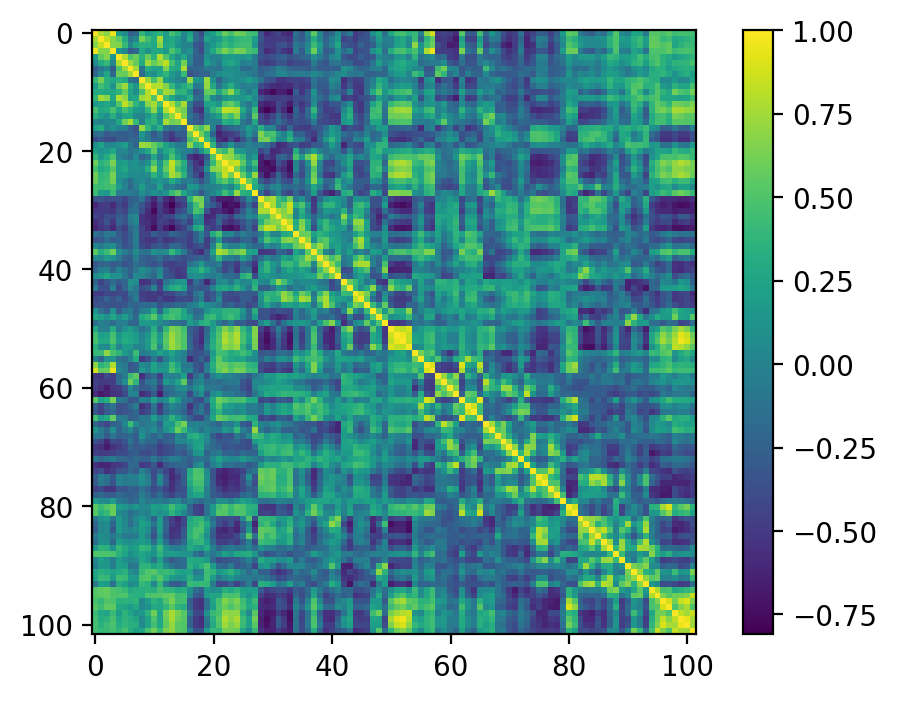

In [7]:
# Making cov matrix
covariance_matrix = np.cov(data_eq_scaled.T)

# Plotting
plt.imshow(covariance_matrix)
plt.colorbar()

vi. What does the off-diagonal activation imply about the independence of the signals measured by the 102 sensors?

- There is quite some covariance between the sensors, which might imply that sensors are picking up the same signals. It might also apply that sensors pick up different signals that have the same strength, at the same time. 

vii. Run `np.linalg.matrix_rank` on the covariance matrix - what integer value do you get? (we'll use this later)

In [8]:
print("Value obtained from matrix_rank function is", np.linalg.matrix_rank(covariance_matrix))

Value obtained from matrix_rank function is 97


viii. Find the eigenvalues and eigenvectors of the covariance matrix using `np.linalg.eig` - note that some of the numbers returned are complex numbers, consisting of a real and an imaginary part (they have a _j_ next to them). We are going to ignore this by only looking at the real parts of the eigenvectors and -values. Use `np.real` to retrieve only the real parts

In [9]:
# Creating two arrays
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

### 2) Create the weighting matrix $W$ and the projected data, $Z$

i. We need to sort the eigenvectors and eigenvalues according to the absolute values of the eigenvalues (use `np.abs` on the eigenvalues).  

In [10]:
eigenvalues = np.abs(eigenvalues)

ii. Then, we will find the correct ordering of the indices and create an array, e.g. `sorted_indices` that contains these indices. We want to sort the values from highest to lowest. For that, use `np.argsort`, which will find the indices that correspond to sorting the values from lowest to highest. Subsequently, use `np.flip`, which will reverse the order of the indices.   

In [11]:
# Sorting indicies based on values from lowest to highest
eigenvalues_index = np.argsort(eigenvalues)

# Flipping indici order to get highest to lowest (np.flip)
sorted_indices = np.flip(eigenvalues_index)

iii. Finally, create arrays of sorted eigenvalues and eigenvectors using the `sorted_indices` array just created. For the eigenvalues, it should like this `eigenvalues = eigenvalues[sorted_indices]` and for the eigenvectors: `eigenvectors = eigenvectors[:, sorted_indices]`

In [12]:
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
sorted_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  68,  69,  70,  73,  74,  75,  76,  77,  78,  84,  85,
        86,  87,  89,  90,  91,  96,  95,  94,  93,  92,  88,  83,  82,
        81,  80,  79,  72,  71,  67,  97,  99,  98, 100, 101], dtype=int64)

iv. Plot the log, `np.log`, of the eigenvalues, `plt.plot(np.log(eigenvalues), 'o')` - are there some values that stand out from the rest? In fact, 5 (noise) dimensions have already been projected out of the data - how does that relate to the matrix rank (Exercise 1.1.vii)  

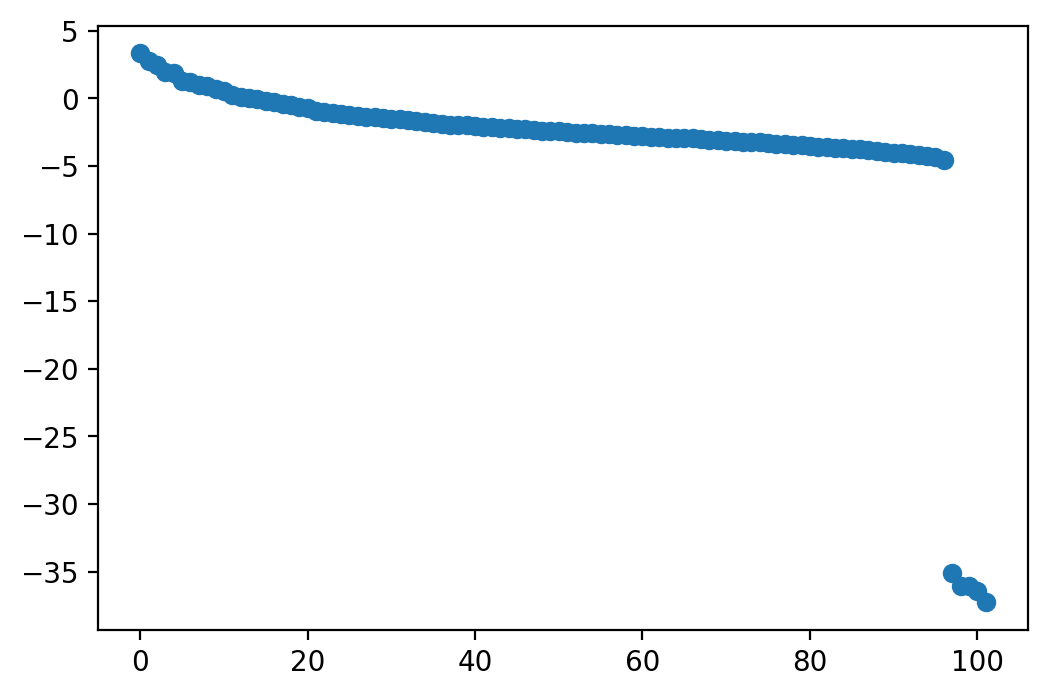

In [14]:
# Plotting
plt.close("all")
plt.plot(np.log(eigenvalues), 'o')

There are five eigenvalues that are very very low, meaning that they explain very little of the variance in the data. Maybe this is why the rank is 97 - the 5 values are so small that they are below the tolerance threshold, and are therefore 0 when using the matrix_rank function.

v. Create the weighting matrix, `W` (it is the sorted eigenvectors)  

In [15]:
W = eigenvectors

vi. Create the projected data, `Z`, $Z = XW$ - (you can check you did everything right by checking whether the $X$ you get from $X = ZW^T$ is equal to your original $X$, `np.isclose` may be of help)

In [16]:
Z = data_eq_scaled @ W

vii. Create a new covariance matrix of the principal components (n=102) - plot it! What has happened off-diagonal and why?


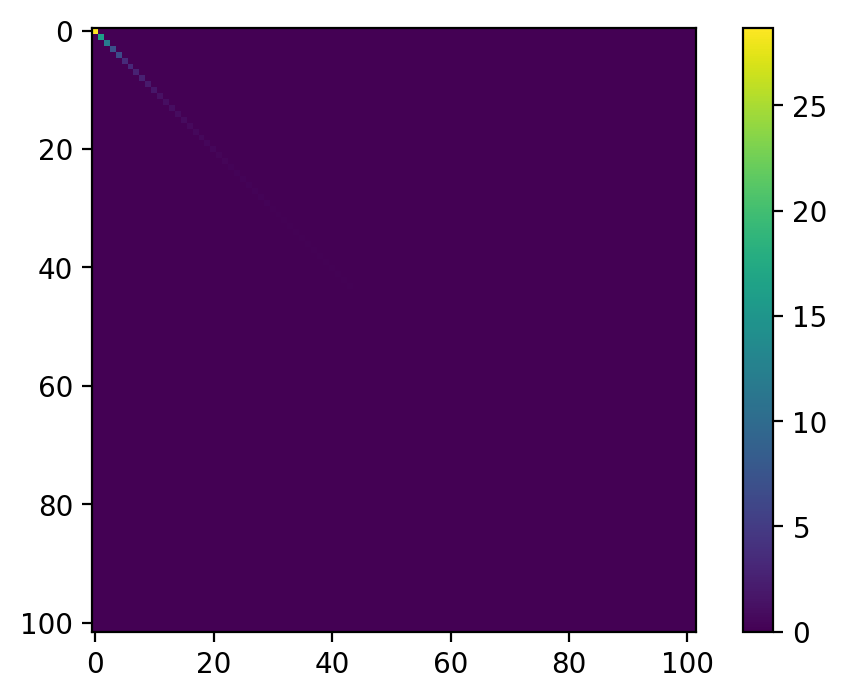

In [17]:
# Create covariance matrix
Z_covariance_matrix = np.cov(Z.T)

# Plotting
plt.imshow(Z_covariance_matrix)
plt.colorbar()

- The covariance has completely disappeared on the off-diagonal, and on the diagonal we see the new features (the prinicipal components) that we have created. Since they're sorted by value, the most explanatory principal component is 0, then 1, then 2 etc.

# EXERCISE 2 - Use logistic regression with cross-validation to find the optimal number of principal components

### 1) We are going to run logistic regression with in-sample validation

i. First, run standard logistic regression (no regularization) based on $Z_{n \times k}$ and `y` (the target vector). Fit (`.fit`) 102 models based on: $k = [1, 2, ..., 101, 102]$ and $d = 102$. For each fit get the classification accuracy, (`.score`), when applied to $Z_{n \times k}$ and $y$. This is an in-sample validation. Use the solver `newton-cg` if the default solver doesn't converge

In [18]:
# Fitting
from sklearn.linear_model import LogisticRegression
logR = LogisticRegression(penalty='none') # no regularisation

# Empty array
sample_scores = []

# Subsetting time
for i in range(102):
    logR.fit(Z[:,0:i+1], y_eq)
    score = logR.score(Z[:,0:i+1], y_eq)
    sample_scores.append(score)

ii. Make a plot with the number of principal components on the _x_-axis and classification accuracy on the _y_-axis - what is the general trend and why is this so?

Text(0.5, 1.0, 'Classification scores by principal component')

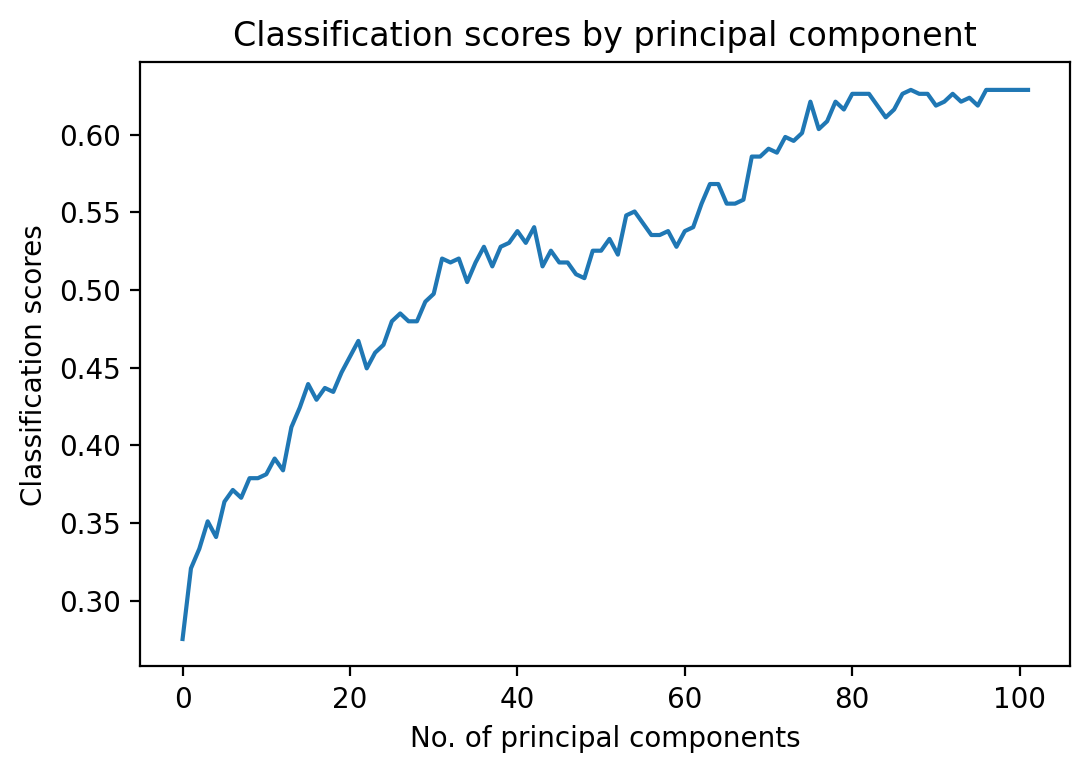

In [19]:
# Plotting
plt.close("all")
plt.figure()
plt.plot(sample_scores)
plt.ylabel("Classification scores")
plt.xlabel("No. of principal components")
plt.title("Classification scores by principal component")

iii. In terms of classification accuracy, what is the effect of adding the five last components? Why do you think this is so?

- The last five components do not add any value to the classification, as mentioned previously when commenting on the eigenvalues. The scores are therefore identical whether you add the terms or not.

### 2) Now, we are going to use cross-validation - we are using `cross_val_score` and `StratifiedKFold` from `sklearn.model_selection`

i. Define the variable: `cv = StratifiedKFold()` and run `cross_val_score` (remember to set the `cv` argument to your created `cv` variable). Use the same `estimator` in `cross_val_score` as in Exercise 2.1.i. Find the mean score over the 5 folds (the default of `StratifiedKFold`) for each $k$, $k = [1, 2, ..., 101, 102]$

In [20]:
# Fitting
from sklearn.linear_model import LogisticRegression
logR = LogisticRegression(penalty='none') # no regularisation

# Preparing cross validation
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = StratifiedKFold()

# Empty array
sample_scores_cv = []

# Subsetting time
for i in range(102):
    logR.fit(Z[:,0:i+1], y_eq)
    scores = cross_val_score(logR, Z[:,0:i+1], y_eq, cv=5)
    sample_scores_cv.append(np.mean(scores))

ii. Make a plot with the number of principal components on the _x_-axis and classification accuracy on the _y_-axis - how is this plot different from the one in Exercise 2.1.ii?

Text(0.5, 1.0, 'Classification scores by principal component (cross validated)')

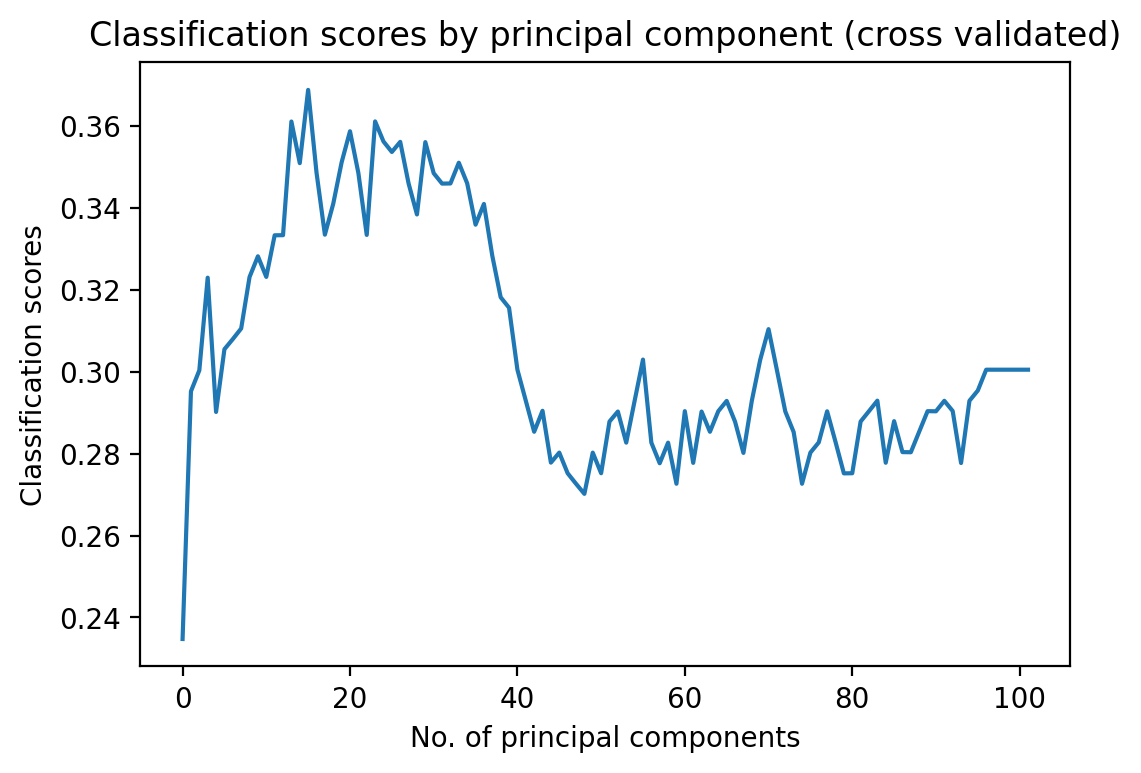

In [21]:
# Plotting
plt.close("all")
plt.figure()
plt.plot(sample_scores_cv)
plt.ylabel("Classification scores")
plt.xlabel("No. of principal components")
plt.title("Classification scores by principal component (cross validated)")

We see that, when going outside of the sample, the model is penalized for complexity because it increaslingly models sample-specific variance (or noise) which doesn't benefit the model when using when given new data.

iii. What is the number of principal components, $k_{max\_accuracy}$, that results in the greatest classification accuracy when cross-validated?  

In [22]:
print("The greatest classification score is", round(np.amax(sample_scores_cv), 4))
print("The number of principal components that result in the best score is", np.argmax(sample_scores_cv)+1)

The greatest classification score is 0.3688
The number of principal components that result in the best score is 16


iv. How many percentage points is the classification accuracy increased with relative to the to the full-dimensional, $d$, dataset

In [2]:
print("The greatest classification score is", round((sample_scores_cv[15] - sample_scores_cv[101])*100, 4), "%", "better than the full dimensional classification.")

NameError: name 'sample_scores_cv' is not defined

v. How do the analyses in Exercises 2.1 and 2.2 differ from one another? Make sure to comment on the differences in optimization criteria.

- In the first one, which is in-sample validation, we don't really penalize overfitting. We get better classification results by modelling the noise in the data when we add PCs. So when we cross validate, we make sure that the PCs needed actually generalize and explain the signal and not just the noise.

### 3) We now make the assumption that $k_{max\_accuracy}$ is representative for each time sample (we only tested for 248 ms). We will use the PCA implementation from _scikit-learn_, i.e. import `PCA` from `sklearn.decomposition`.

i. For __each__ of the 251 time samples, use the same estimator and cross-validation as in Exercises 2.1.i and 2.2.i. Run two analyses - one where you reduce the dimensionality to $k_{max\_accuracy}$ dimensions using `PCA` and one where you use the full data. Remember to scale the data (for now, ignore if you get some convergence warnings - you can try to increase the number of iterations, but this is not obligatory)  

In [24]:
# PCA with k_max_accuracy components (16)
from sklearn.decomposition import PCA
pca = PCA(n_components=16)
scores_pca_k = []

# Subsetting time
for i in range(251):
    std = sc.fit_transform(data_eq[:,:,i])
    pcs = pca.fit_transform(std)
    logR.fit(pcs, y_eq)
    scores = cross_val_score(logR, pcs, y_eq, cv=5)
    scores_pca_k.append(np.mean(scores))

# PCA with all dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=102)
scores_pca_d = []

# Subsetting time
for i in range(251):
    std = sc.fit_transform(data_eq[:,:,i])
    pcs = pca.fit_transform(std)
    logR.fit(pcs, y_eq)
    scores = cross_val_score(logR, pcs, y_eq, cv=5)
    scores_pca_d.append(np.mean(scores))

ii. Plot the classification accuracies for each time sample for the analysis with PCA and for the one without in the same plot. Have time (ms) on the _x_-axis and classification accuracy on the _y_-axis

Text(0.5, 1.0, 'Classification scores with k=16')

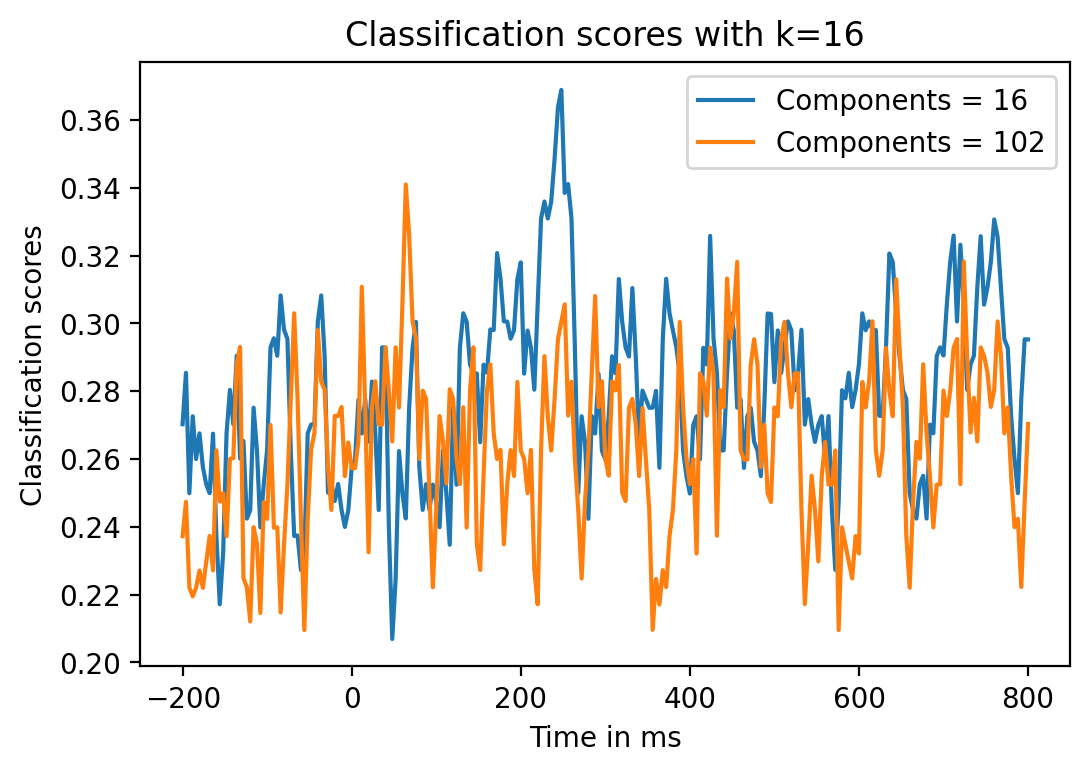

In [25]:
# Plotting
plt.close("all")
plt.figure()
plt.plot(times, scores_pca_k, label="Components = 16")
plt.plot(times, scores_pca_d, label="Components = 102")
plt.legend()
plt.ylabel("Classification scores")
plt.xlabel("Time in ms")
plt.title("Classification scores with k=16")

iii. Describe the differences between the two analyses - focus on the time interval between 0 ms and 400 ms - describe in your own words why the logistic regression performs better on the PCA-reduced dataset around the peak magnetic activity

- As mentioned before, using all principal components, you will likely overfit your data. This means that, even when cross validating, some of the PCs explain very little OR explain noise, which isn't favorable. So, at the point where it's easier to classify PAS (i.e. were there is more of a signal), which happens after the stimulus onset, it becomes clear that complexity is penalized heavier, and the 16-component model performs better.